In [255]:
# Analysing data set

import pandas as pd
import numpy as np
from scipy.interpolate import splrep, splev, interp1d, splprep, BSpline
import datashader as ds
import colorcet as cc
import matplotlib.pyplot as plt
import seaborn as sns
import openrouteservice as ors
from openrouteservice import directions
import time

In [6]:
df = pd.read_csv('Daily_Data_EV.csv')

In [7]:
# settle for the following times
    # 3:00 - 10:00 (Morning)
    # 10:00 - 17:00 (Afternoon)
    # 17:00 - 24:00 (Evenning)

# split departure time into separate columns (2) for hours and minutes
df_time_split = df['departure_time'].str.split(pat=':',expand=True).astype(int)

# converting hour-minute format to float and joining back into one number
    # int value + 0. decimal value
time_num_decimal =  df_time_split[0] + df_time_split[1]/60

# put time decimal into pandas dataframe to join back with original
df_time_decimal = pd.DataFrame({'time_decimal':time_num_decimal})
df_time_int = pd.DataFrame({'time_int':df_time_split[0]})

# joining new column with time decimal and int with main dataframe
df = df.join(df_time_decimal).join(df_time_int)

Text(0.5, 0, 'Time (h)')

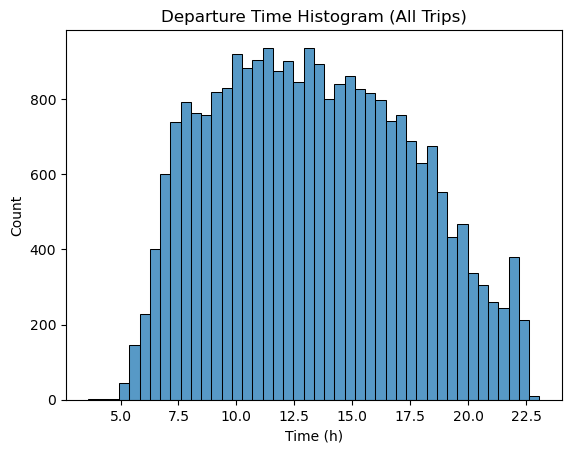

In [323]:
# histogram
sns.histplot(df["time_decimal"])
plt.title("Departure Time Histogram (All Trips)")
plt.xlabel("Time (h)")

In [8]:
# separating dataset with only EV-#, Trip, Departure Time and Decimal Time
cleaned_df = df[['EV Number', 'Trip', 'departure_time', 'time_decimal', 'time_int', 't_dist']]

# splitting coordinate cells by ',' into separate latitude and longitude columns for source and destination
    # remember to convert into float
source_df = df['source'].str.split(pat=",", expand=True).astype('float32')
destination_df = df['destination'].str.split(pat=",", expand=True).astype('float32')

# joining back into separate columns
cleaned_df = pd.concat([cleaned_df, source_df, destination_df], axis=1)

# renaming columns
cleaned_df.columns = ['EV_Number', 'Trip','departure_time', 'time_decimal', 'time_int', 'distance', 'source_lat', 'source_lon', 'destination_lat', 'destination_lon']

cleaned_df.head(10)


,EV_Number,Trip,departure_time,time_decimal,time_int,distance,source_lat,source_lon,destination_lat,destination_lon
0,EV-1,1_8,06:35,6.583333,6,1.878,36.044201,-86.730103,36.047298,-86.714104
1,EV-1,8_2,06:59,6.983333,6,27.165,36.047298,-86.714104,36.057201,-86.977997
2,EV-1,2_2,08:15,8.250000,8,42.277,36.057201,-86.977997,36.277302,-86.818604
3,EV-1,2_8,09:15,9.250000,9,19.548,36.277302,-86.818604,36.189499,-86.729202
4,EV-1,8_2,11:45,11.750000,11,15.729,36.189499,-86.729202,36.151600,-86.844398
5,EV-1,2_12,12:01,12.016667,12,10.877,36.151600,-86.844398,36.133400,-86.766998
6,EV-1,12_1,15:21,15.350000,15,16.534,36.133400,-86.766998,36.134399,-86.633003
7,EV-2,1_2,07:54,7.900000,7,61.727,36.124199,-86.545197,36.315701,-86.867996
8,EV-2,2_6,18:47,18.783333,18,45.226,36.315701,-86.867996,36.042198,-86.745598
9,EV-2,6_6,19:40,19.666667,19,20.621,36.042198,-86.745598,36.174500,-86.750900


Text(0.5, 1.0, 'Distance Traveled Histogram (All Trips)')

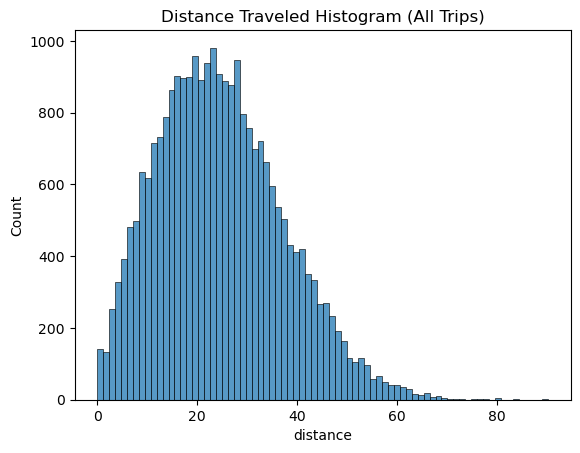

In [318]:
sns.histplot(cleaned_df["distance"])
plt.title("Distance Traveled Histogram (All Trips)")

In [93]:
def get_coord_df(ev_set):
    # merging source and destination into one series so they are connected in order when graphed
    ev_source = ev_set[['source_lat', 'source_lon']]
    ev_destination = ev_set[['destination_lat', 'destination_lon']]

    # realization: every source is the destination of the previous trip, except for the first one (and last)
    # just need append destination one row to source and join the datasets

    # getting last row of destination
    last_row = ev_destination.iloc[-1]
    # renaming labels to match source df when concatenating so index match on concatenation
    last_row.index = ev_source.columns

    # appending last row to end with concatenate (taking transpose of row)
    return_df = pd.concat([ev_source,last_row.to_frame().T], axis=0, ignore_index=True)
    return_df.columns = ['lat', 'lon']

    return return_df

In [91]:
# Getting map coordinate boundaries
coord_df = get_coord_df(cleaned_df)

# 0 is 3 o'clock, 1 is 6 o'clock, 2 is 9 o'clock, 3 is 12 o'clock
box_boundaries = [coord_df['lon'].max(), coord_df['lat'].min(), coord_df['lon'].min(), coord_df['lat'].max()]

box_boundaries

[-86.51969909667969, 35.982398986816406, -87.04309844970703, 36.38169860839844]

In [92]:
coord_df

,lat,lon
0,36.044201,-86.730103
1,36.047298,-86.714104
2,36.057201,-86.977997
3,36.277302,-86.818604
4,36.189499,-86.729202
...,...,...
25852,36.035702,-86.961899
25853,36.268700,-86.702400
25854,36.072701,-86.925102
25855,36.046600,-86.721703


In [8]:
# Separating dataset into morning
morning_cleaned_df = cleaned_df[cleaned_df['time_decimal']<10]

# Separating dataset into midday
midday_cleaned_df = cleaned_df[(cleaned_df['time_decimal']>=10) & (cleaned_df['time_decimal']<17)]

# Separating dataset into evening
evening_cleaned_df = cleaned_df[(cleaned_df['time_decimal']>=17)]

# defining python dict for ease of access
df_blocks = {
    "morning": {
        "name": "morning",
        "dataframe": morning_cleaned_df
        },
    "midday": {
        "name": "midday",
        "dataframe": midday_cleaned_df
        },
    "evening": {
        "name": "evening",
        "dataframe": evening_cleaned_df
        }
}

print(morning_cleaned_df.count(), midday_cleaned_df.count(), evening_cleaned_df.count())

EV_Number          6474
Trip               6474
departure_time     6474
time_decimal       6474
distance           6474
source_lat         6474
source_lon         6474
destination_lat    6474
destination_lon    6474
dtype: int64 EV_Number          13635
Trip               13635
departure_time     13635
time_decimal       13635
distance           13635
source_lat         13635
source_lon         13635
destination_lat    13635
destination_lon    13635
dtype: int64 EV_Number          5747
Trip               5747
departure_time     5747
time_decimal       5747
distance           5747
source_lat         5747
source_lon         5747
destination_lat    5747
destination_lon    5747
dtype: int64


In [82]:
# list for 24h blocks
time_blocks_24 = []

# ranges from 0 to 23 (total 24)
for x in range(0,24):
    next_x = x + 1
    dict = {
        "name" : "hour-{x}".format(x=x),
        "dataframe" : cleaned_df[(cleaned_df['time_decimal']>=x) & (cleaned_df['time_decimal']<next_x)]
    }
    time_blocks_24.append(dict)

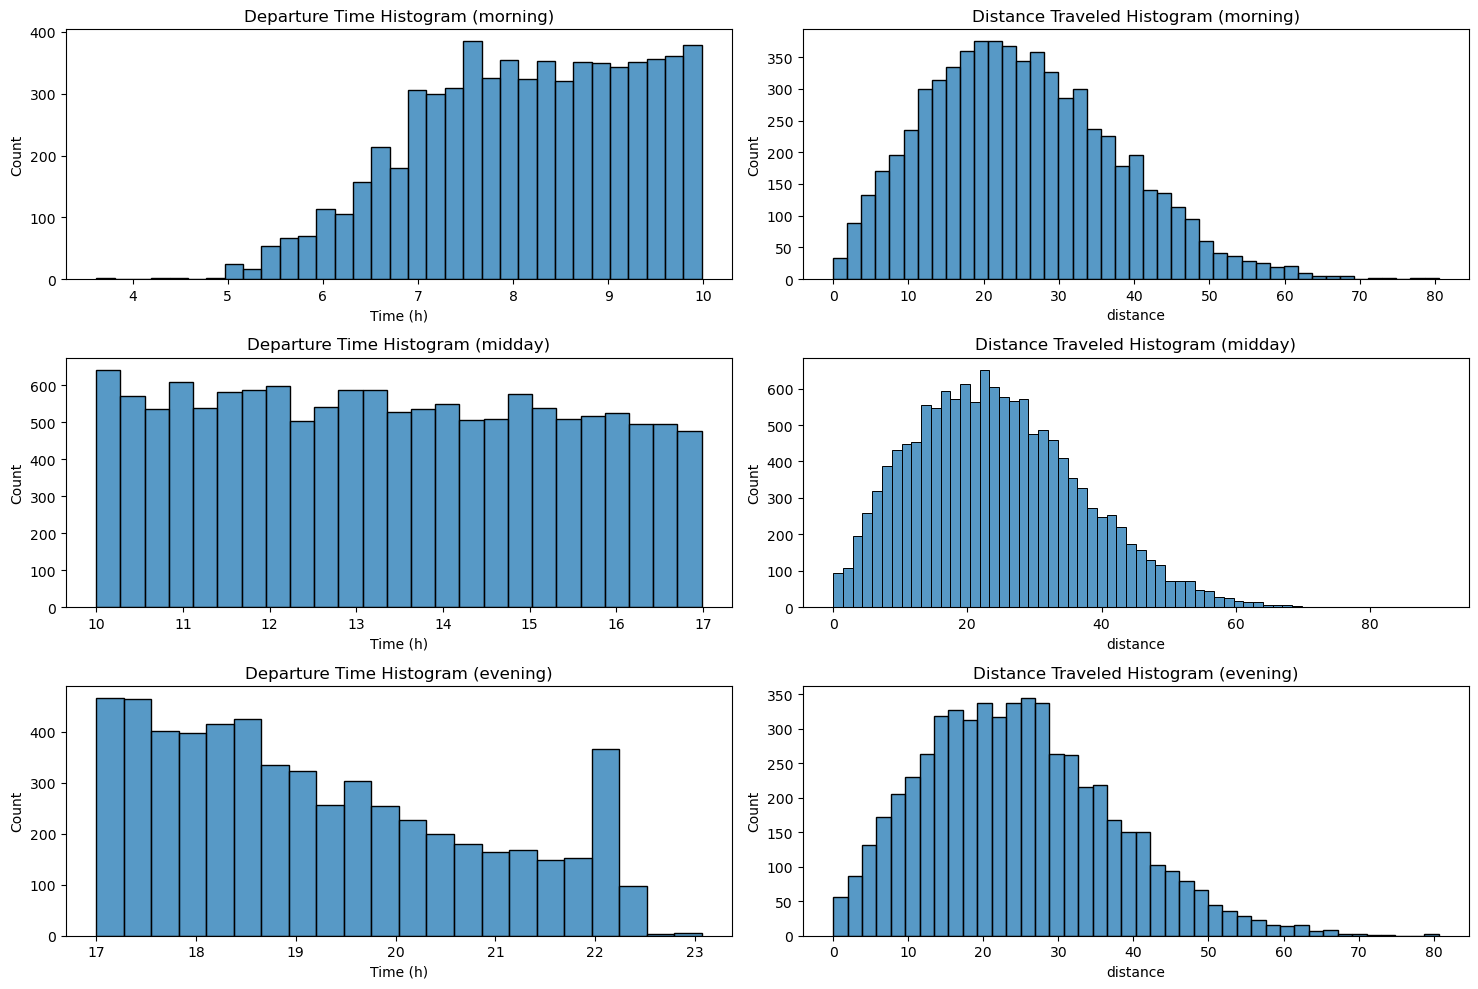

In [345]:
block_plot_index = 1

plt.figure(figsize=(15, 10))

for block in df_blocks:
    df = df_blocks[block]["dataframe"]

    # time histogram
    plt.subplot(3, 2, block_plot_index)
    plt.tight_layout()
    sns.histplot(df["time_decimal"])
    plt.title("Departure Time Histogram ({name})".format(name=block))
    plt.xlabel("Time (h)")

    block_plot_index = block_plot_index + 1

    # distance histogram
    plt.subplot(3, 2, block_plot_index)
    plt.tight_layout()
    sns.histplot(df["distance"])
    plt.title("Distance Traveled Histogram ({name})".format(name=block))

    block_plot_index = block_plot_index + 1

plt.show()

In [133]:
# getting EV-1 set as an example to convert into map
ev1_cleaned_df = cleaned_df[cleaned_df['EV_Number']=="EV-1"]

ev1_cleaned_df

,EV_Number,Trip,departure_time,time_decimal,time_int,distance,source_lat,source_lon,destination_lat,destination_lon
0,EV-1,1_8,06:35,6.583333,6,1.878,36.044201,-86.730103,36.047298,-86.714104
1,EV-1,8_2,06:59,6.983333,6,27.165,36.047298,-86.714104,36.057201,-86.977997
2,EV-1,2_2,08:15,8.250000,8,42.277,36.057201,-86.977997,36.277302,-86.818604
3,EV-1,2_8,09:15,9.250000,9,19.548,36.277302,-86.818604,36.189499,-86.729202
4,EV-1,8_2,11:45,11.750000,11,15.729,36.189499,-86.729202,36.151600,-86.844398
5,EV-1,2_12,12:01,12.016667,12,10.877,36.151600,-86.844398,36.133400,-86.766998
6,EV-1,12_1,15:21,15.350000,15,16.534,36.133400,-86.766998,36.134399,-86.633003


In [ ]:
# merging source and destination into one series so they are connected in order when graphed
ev1_source = ev1_cleaned_df[['source_lat', 'source_lon']]
ev1_destination = ev1_cleaned_df[['destination_lat', 'destination_lon']]

# realization: every source is the destination of the previous trip, except for the first one
# just need shift by one row and join the datasets

# getting last row of destination
last_row = ev1_destination.iloc[-1]
# renaming labels to match source df when concatenating
last_row.index = pd.Index(['lat', 'lon'])
ev1_source.columns = pd.Index(['lat', 'lon'])

ev1_coord_df = pd.concat([ev1_source,last_row.to_frame().T], axis=0, ignore_index=True)

# reversing because OpenRouteService API expects in (lon, lat) format
ev1_coord_list = ev1_coord_df.values.tolist()
# list comprehension reversing items in coordinate pair 
ev1_coord_list = [list(reversed(coord_pair)) for coord_pair in ev1_coord_list]
ev1_coord_list

In [11]:
# Accessing OpenRouteService API to get a route for the coordinates of EV1

test_coordinates = ((8.34234,48.23424),(8.34423,48.26424))

# passing key
# client = ors.Client(key='eyJvcmciOiI1YjNjZTM1OTc4NTExMTAwMDFjZjYyNDgiLCJpZCI6ImZhOGU1ZWU3MzUzNjQ5ODZiYzBjMDA1NTdkMTRhMDEyIiwiaCI6Im11cm11cjY0In0=')

client = ors.Client(base_url='http://localhost:8080/ors')


### EV 1 Route Template

In [ ]:
# measuring time for one
ev1_start_time = time.time()

# ----------------------

# getting route from API, returns list with coordinate pair list
route = client.directions(ev1_coord_list, profile="driving-car", format="geojson")["features"][0]["geometry"]["coordinates"]

# putting list into pandas dataframe
ev1_route_df = pd.DataFrame(route, columns=['lon', 'lat'])

# plotting in matplotlib
plt.figure(figsize=(5,5))
plt.tight_layout()
ax = sns.lineplot(data=ev1_route_df, x='lon', y='lat', sort=False, lw=3, estimator=None)
plt.axis('off')

# # aesthetics
# ax.set_title("EV-1 Trip")

ev1_end_time = time.time()
ev1_elapsed_time = ev1_end_time - ev1_start_time

plt.savefig("ev-1-route-test.png", dpi=100)
plt.close()

#-----------------------

print("Elapsed Time(s): {elap}".format(elap=round(ev1_elapsed_time,2)))

Elapsed Time(s): 0.17


[-86.729972, 36.044238]

In [11]:
def get_coord_list(df):
    # putting into list because OpenRouteService expects list/tuple
        # ex: [[34.52, -89.34], [34.23, -89.43], [34.56, -89.03]]
    coord_list = df.values.tolist()

    # list comprehension reversing items in coordinate pair 
    # reversing items because OpenRouteService API expects in (lon, lat) format and not (lat, lon)
        # ex: [[-89.34, 34.52, ], [-89.43, 34.23], [-89.03, 34.56]]
    coord_list = [list(reversed(coord_pair)) for coord_pair in coord_list]

    return coord_list

In [161]:
time_blocks_24[3]["dataframe"]

,EV_Number,Trip,departure_time,time_decimal,time_int,distance,source_lat,source_lon,destination_lat,destination_lon
20138,EV-5465,1_2,03:37,3.616667,3,14.478,36.0858,-86.845901,36.0774,-86.977997


In [9]:
# get coordinates by time range
    # filter df by time range
    # get route for every motif / row in df
    # append (coords, dept time) to coord list

# can pretty much ignore EV number

"""
returns points in df for time range (inclusive, exclusive]
    like 14:00 to 15:00 (up to 15:00, not included)
"""
def get_points(df, time_range):
    range_df = df[(df["time_int"] >= time_range[0]) & (df["time_int"] < time_range[1])]

    # 3d list - [lon, lat, time]
        # ex: [[34.52, -89.34, 6], [34.23, -89.43, 7], [34.56, -89.03, 9]]
    list_used = []

    for row in range_df.itertuples():
        depart_time = row.time_int
        coords_pair = [[row.source_lon, row.source_lat],[row.destination_lon, row.destination_lat]]

        # getting route from API, returns list with coordinate pair list
            # returns something similar to input (ex just above) except with more datapoints
        try:
            api_response = client.directions(coords_pair, profile="driving-car", format="geojson")
            route_coord_list = api_response["features"][0]["geometry"]["coordinates"]

            # append coordinate list to master points list
            for coord_pair in route_coord_list:
                append_trio = coord_pair
                append_trio.append(depart_time)
                list_used.append(append_trio)

        except ors.exceptions.ApiError as e:
            # catching errors for unreachable routes (mostly ev's that stopped inside airports etc., negligible)
            api_error_code = e.args[0]
            ors_error_code = e.args[1]["error"]["code"]
            ors_error_msg = e.args[1]["error"]["message"]
            # print("API Error: ", api_error_code)
            # print("Error Code: ", ors_error_code)
            # print("Message: ", ors_error_msg)
            # print()
        
    return list_used

In [82]:

df_3 = cleaned_df[cleaned_df["EV_Number"]=="EV-3"]
value_arr = df_3.iloc[0].tolist()
coords_pair_3 = [[float(value_arr[7]), float(value_arr[6])], [float(value_arr[9]), float(value_arr[8])]]

api_response_3 = client.directions(coords_pair_3, profile="driving-car", format="geojson")
route_coord_list_3 = api_response_3["features"][0]["geometry"]["coordinates"]

for coord_paid_arr in route_coord_list_3:
    coord_paid_arr.append(value_arr[4])

In [83]:
points_3 = route_coord_list_3
points_3_df = pd.DataFrame(points_3, columns=['lon', 'lat', 'time_int'])
points_3_df

,lon,lat,time_int
0,-86.701929,36.273028,7
1,-86.702644,36.273083,7
2,-86.703387,36.273120,7
3,-86.703646,36.273133,7
4,-86.704176,36.273159,7
...,...,...,...
264,-86.778529,36.163064,7
265,-86.778082,36.162386,7
266,-86.778712,36.162123,7
267,-86.779334,36.161865,7


In [85]:
points_3_sorted_df = points_3_df.sort_values(by=['lon'])

In [313]:
x = points_3_sorted_df['lon'].to_numpy()
y = points_3_sorted_df['lat'].to_numpy()

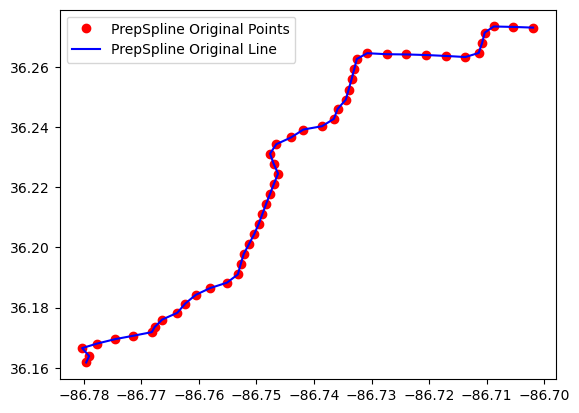

In [369]:
drop_pc = 0.8
drop_n = int(np.floor(len(points_3_df)*drop_pc))
drop_indices = np.random.choice(points_3_df.index, drop_n, replace=False)
dropped_points_3_df = points_3_df.drop(drop_indices)

x_dropped = dropped_points_3_df['lon'].to_numpy()
y_dropped = dropped_points_3_df['lat'].to_numpy()

n_interior_knots = 60
qs = np.linspace(0, 1, n_interior_knots+2)[1:-1]
knots = np.quantile(x, qs)

# Find the B-spline representation (cubic spline, with some smoothing)
tck = splrep(x, y, t=knots, s=2, k=3)

# Evaluate the spline at a finer set of points
x_new = np.linspace(x.min(), x.max(), 269)
y_smooth = splev(x_new, tck)

# unsorted values
x_unsorted = points_3_df['lon'].to_numpy()
y_unsorted = points_3_df['lat'].to_numpy()

# prep
new_t = np.linspace(0, 1, 50)
new_tck, u = splprep([x_unsorted, y_unsorted], s=0)
new_points = splev(new_t, new_tck)

dropped_t = np.linspace(0, 1, 50)
tck_dropped, u_dropped = splprep([x_dropped, y_dropped], s=0)
new_points_dropped = splev(dropped_t, tck_dropped)

# interp1d
f = interp1d(x_unsorted, y_unsorted, kind='linear', assume_sorted=False)
y_new = f(x_new)

# Plot the original data and the smoothed spline
# plt.plot(x, y, 'o', label='Original Data')
# plt.plot(x_dropped, y_dropped, 'o', label='Dropped Data')
# plt.plot(x_new, y_smooth, label='Smoothed Spline')
# plt.plot(x_new, y_new, 'o', label='Inter1D')
plt.plot(new_points[0], new_points[1], 'ro', label='PrepSpline Original Points')
plt.plot(new_points[0], new_points[1], 'b-', label='PrepSpline Original Line')
# plt.plot(new_points_dropped[0], new_points_dropped[1], 'g-', label='PrepSpline Dropped Line')
plt.legend()
plt.show()

In [291]:
x_new

array([-86.780703  , -86.78040907, -86.78011513, -86.7798212 ,
       -86.77952727, -86.77923334, -86.7789394 , -86.77864547,
       -86.77835154, -86.7780576 , -86.77776367, -86.77746974,
       -86.77717581, -86.77688187, -86.77658794, -86.77629401,
       -86.77600007, -86.77570614, -86.77541221, -86.77511828,
       -86.77482434, -86.77453041, -86.77423648, -86.77394254,
       -86.77364861, -86.77335468, -86.77306075, -86.77276681,
       -86.77247288, -86.77217895, -86.77188501, -86.77159108,
       -86.77129715, -86.77100322, -86.77070928, -86.77041535,
       -86.77012142, -86.76982749, -86.76953355, -86.76923962,
       -86.76894569, -86.76865175, -86.76835782, -86.76806389,
       -86.76776996, -86.76747602, -86.76718209, -86.76688816,
       -86.76659422, -86.76630029, -86.76600636, -86.76571243,
       -86.76541849, -86.76512456, -86.76483063, -86.76453669,
       -86.76424276, -86.76394883, -86.7636549 , -86.76336096,
       -86.76306703, -86.7627731 , -86.76247916, -86.76

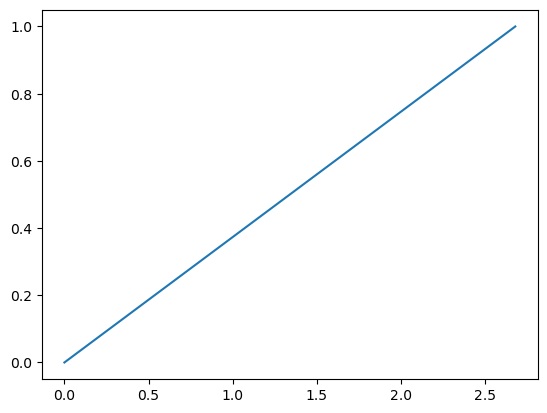

In [227]:
plt.plot([x/100 for x in range(0,269)], u)
plt.show()

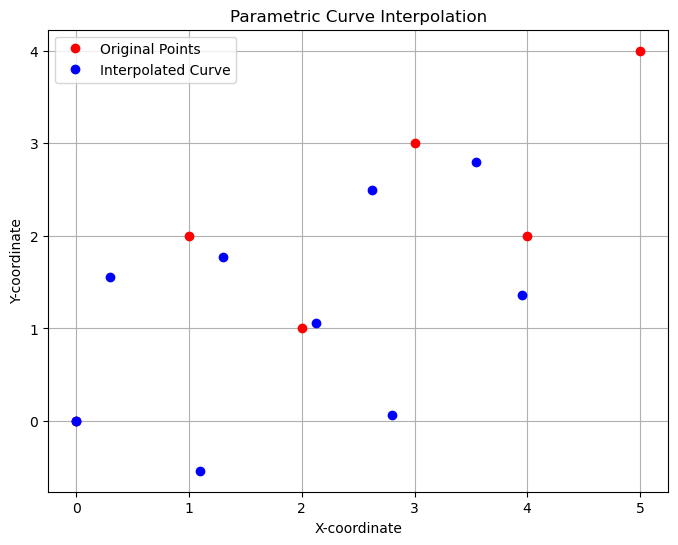

In [350]:
# 1. Define the data points for the parametric curve
# These are your (x, y) coordinates along the curve
x_ex = np.array([0, 1, 2, 3, 4, 5])
y_ex = np.array([0, 2, 1, 3, 2, 4])

# 2. Fit splines to the data using splprep
# splprep takes a list of arrays representing the curve in N-D space.
# s=0 ensures the spline passes through all input points (no smoothing).
# per=True can be used for closed curves if the start and end points are the same.
tck, u = splprep([x_ex, y_ex], s=0, per=True)

# 3. Evaluate the fitted splines at new parameter values using splev
# np.linspace creates a sequence of evenly spaced parameter values for the  curve.
u_new = np.linspace(u.min(), u.max(), 10) # 100 points for a smooth curve
x_new, y_new = splev(u_new, tck)

# 4. Plot the original points and the interpolated curve
plt.figure(figsize=(8, 6))
plt.plot(x_ex, y_ex, 'or', label='Original Points') # 'or' for red circles
plt.plot(x_new, y_new, 'ob', label='Interpolated Curve') # '-b' for blue line
plt.title('Parametric Curve Interpolation')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.grid(True)
plt.show()

In [351]:
y_new

array([ 0.        ,  1.56139146,  1.77003105,  1.05655122,  2.4935427 ,
        2.79435954,  1.36406181,  0.07095759, -0.53613371,  0.        ])

In [227]:
ds_points_6 = get_points(cleaned_df, [0,8])

augmented_points_df_6 = pd.DataFrame(ds_points_6, columns=['lon', 'lat', 'time_int'])
augmented_points_df_6['time_int'] = augmented_points_df_6['time_int'].astype('category')

len(augmented_points_df_6)

839630

In [240]:
ds_canvas_6 = ds.Canvas(plot_width=500, plot_height=500)

agg_6 = ds_canvas_6.points(augmented_points_df_6, 'lon', 'lat', ds.by('time_int', ds.count()))

,

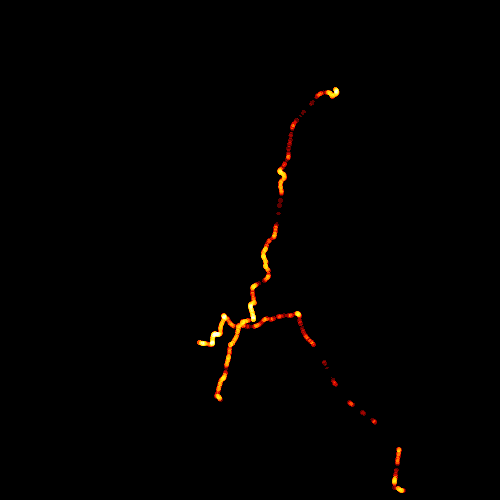
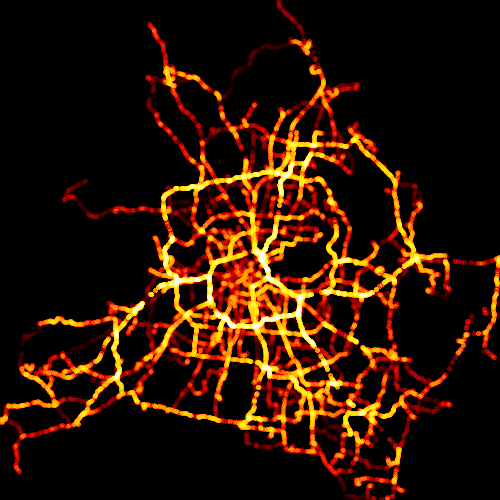

In [242]:
# shading original image with black background
img_6 = ds.tf.set_background(ds.tf.shade(ds.tf.spread(agg_6.sel(time_int='4'), px=2), cmap=cc.fire), "black")
img_7 = ds.tf.set_background(ds.tf.shade(ds.tf.spread(agg_6.sel(time_int='7'), px=2), cmap=cc.fire), "black")

# displaying both images next to each other
ds.tf.Images(img_6, img_7)

In [86]:
time_list = [6, 9]

time_block_df_6 = time_blocks_24[6]["dataframe"]

time_block_df_9 = time_blocks_24[9]["dataframe"]

ds_points_6 = get_points(time_block_df_6)

ds_points_9 = get_points(time_block_df_9)


augmented_points_df_6 = pd.DataFrame(ds_points_6, columns=['lon', 'lat', 'time_int'])

augmented_points_df_9 = pd.DataFrame(ds_points_9, columns=['lon', 'lat'])



KeyboardInterrupt



In [68]:
(agg_6.data.max(), agg_9.data.max())

(381, 879)

,

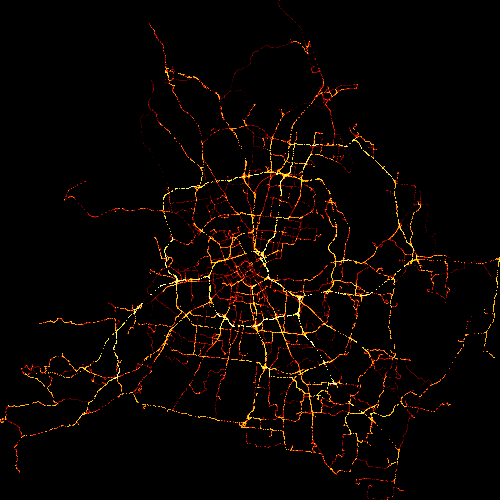
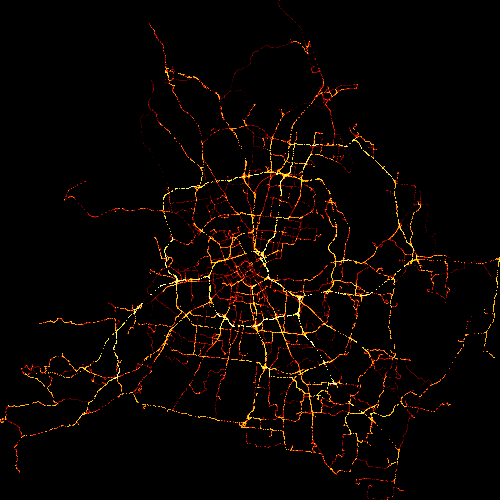

In [66]:
# shading original image with black background
img_6 = ds.tf.set_background(ds.tf.shade(agg_9, cmap=cc.fire), "black")
img_9 = ds.tf.set_background(ds.tf.shade(agg_9, cmap=cc.fire), "black")

# displaying both images next to each other
ds.tf.Images(img_6, img_9)

In [13]:
# morning datashader plotting
morning_points_df = pd.DataFrame(df_blocks["morning"]["point_list"], columns=['lon', 'lat'])
morning_canvas = ds.Canvas(plot_width=500, plot_height=500)
morning_agg = morning_canvas.points(morning_points_df, 'lon', 'lat', ds.count())

# midday datashader plotting
midday_points_df = pd.DataFrame(df_blocks["midday"]["point_list"], columns=['lon', 'lat'])
midday_canvas = ds.Canvas(plot_width=500, plot_height=500)
midday_agg = midday_canvas.points(midday_points_df, 'lon', 'lat', ds.count())

# evening datashader plotting
evening_points_df = pd.DataFrame(df_blocks["evening"]["point_list"], columns=['lon', 'lat'])
evening_canvas = ds.Canvas(plot_width=500, plot_height=500)
evening_agg = evening_canvas.points(evening_points_df, 'lon', 'lat', ds.count())

,

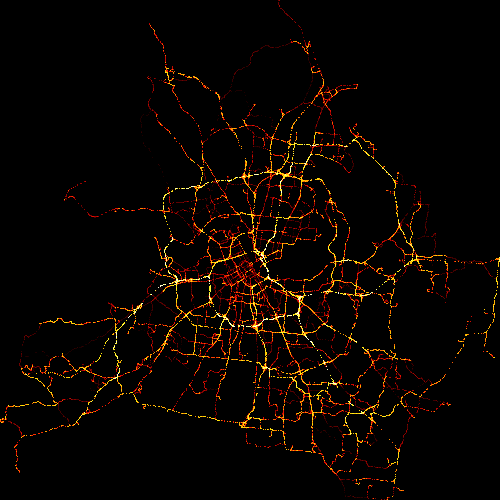
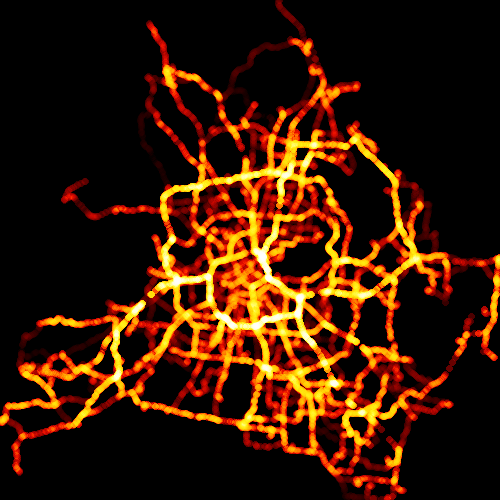

In [14]:
# shading original image with black background
original_img = ds.tf.set_background(ds.tf.shade(morning_agg, cmap=cc.fire), "black")

# shading image with spread on pixels to "densify" it
spread_img = ds.tf.set_background(ds.tf.shade(ds.tf.spread(morning_agg, px=3), cmap=cc.fire), "black")

# displaying both images next to each other
ds.tf.Images(original_img, spread_img)



,

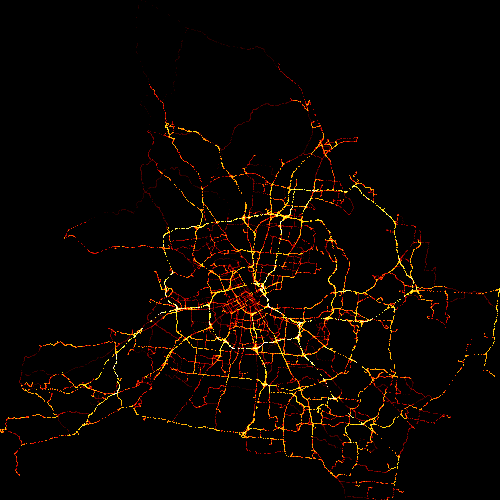
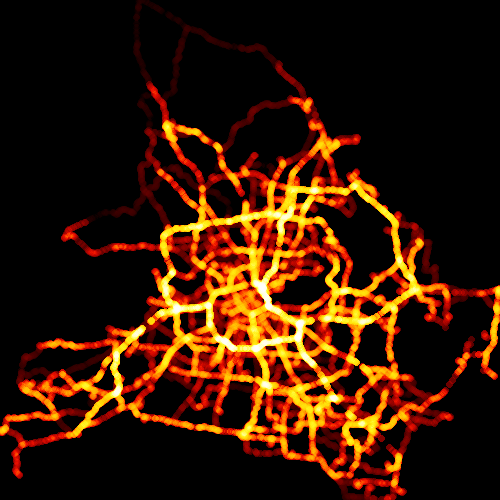

In [17]:
# shading original image with black background
original_img = ds.tf.set_background(ds.tf.shade(midday_agg, cmap=cc.fire), "black")

# shading image with spread on pixels to "densify" it
spread_img = ds.tf.set_background(ds.tf.shade(ds.tf.spread(midday_agg, px=3), cmap=cc.fire), "black")

# displaying both images next to each other
ds.tf.Images(original_img, spread_img)

,

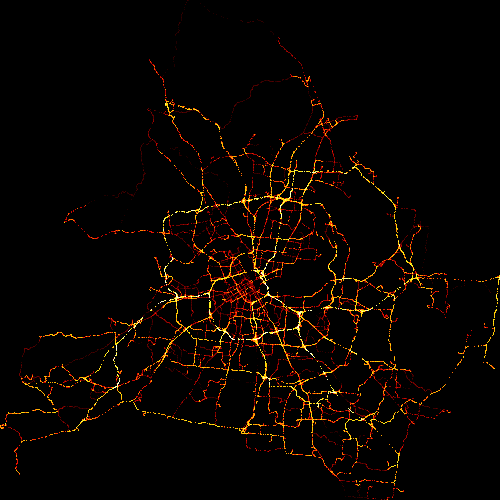
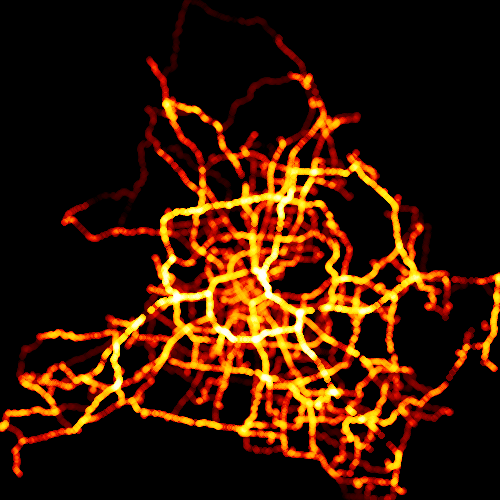

In [18]:
# shading original image with black background
original_img = ds.tf.set_background(ds.tf.shade(evening_agg, cmap=cc.fire), "black")

# shading image with spread on pixels to "densify" it
spread_img = ds.tf.set_background(ds.tf.shade(ds.tf.spread(evening_agg, px=3), cmap=cc.fire), "black")

# displaying both images next to each other
ds.tf.Images(original_img, spread_img)

